# Assignment 4
### Do three of six.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

----------
Trial Goal:

The goal of the trial is to determine whether or not an invasive or non-invasisve strategy for the recovery after surgery forthis type of surgery is better for patient outcomes. Patients have Ischemic heart disease, at least moderate inducible ischemia and advanced chronic kidney disease.

Trial Design:

The trial has two groups the ones in the invasive strategy group and the one in the conservative strategy group. The invasive strategy gorups had 2-3 procedures Cardiac Catheterization, Coronary Artery Bypass Graft Surgery, and Percutaneous Coronary Intervention followed by the same lifestyle channges and drugs as the conservative group. The conservative group only did the lifestyle changes and the drugs following the procedure. The allocation was randomized and the intervention model was Parallel Assignment, meaning te groups were selected randomly and the intervention was run by the two groups in parallel.

Results:

The "Incidence of Death from Any Cause or Myocardial Infarction" is a contingency table because it is showing the association of the two strategies with the incidence of death. It is basically showing the association between the treatment and the number of deaths.

Difference in Survival Rates:

The difference between the survival rates according to that table is that the conservative strategy was actually 1.5% less likely to die than the invasive strategy(The standard of care). The invasive strategy was 1.5% more likely to die than the conservative strategy.



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

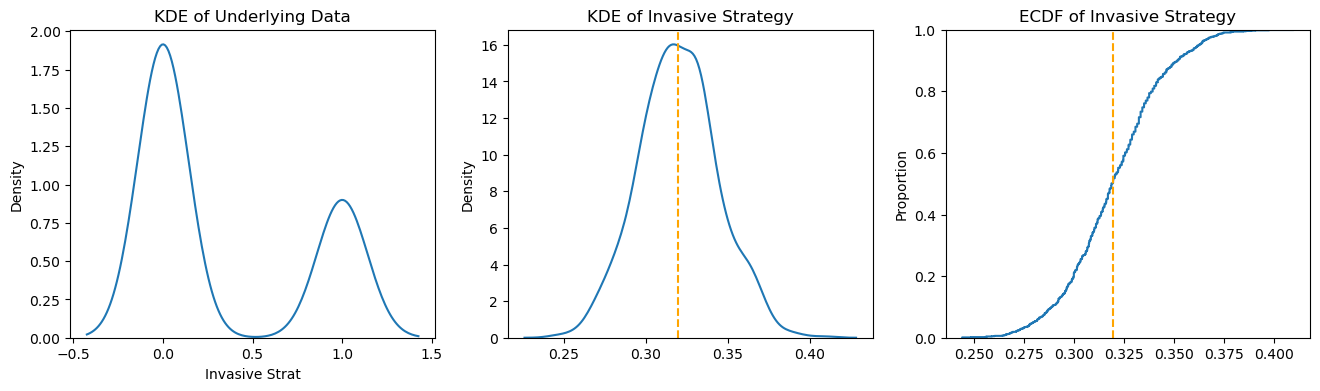

Variance of estimates is: 0.0005859608173678678


In [19]:
#Bootstap the survival rates
invasive_strat = []
conservative_strat = []
for i in range(388):
    if i < 124:
        invasive_strat.append(1)
    else:
        invasive_strat.append(0)

for i in range(392):
    if i < 129:
        conservative_strat.append(1)
    else:
        conservative_strat.append(0)

df1 = pd.DataFrame({'Invasive Strat': invasive_strat})
df2 = pd.DataFrame({'Conservative Strat': conservative_strat})
df = pd.concat([df1,df2], axis=1)

def simulate(var, df, fcn,title, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title=f'KDE of {title}')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title=f'ECDF of {title}')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates


simulate(var = 'Invasive Strat', df=df,fcn=np.mean, title = "Invasive Strategy");

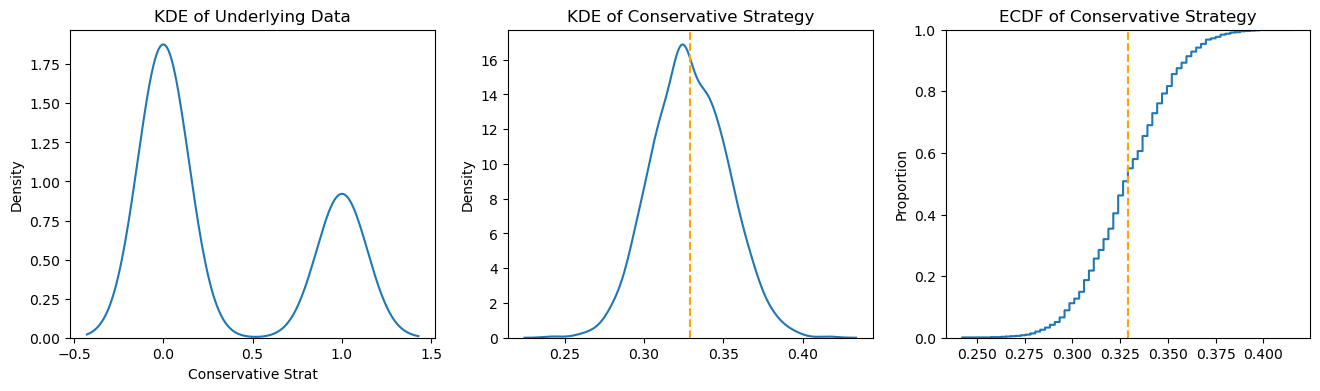

Variance of estimates is: 0.0005505980841316118


In [20]:
simulate('Conservative Strat', df, np.mean, title = "Conservative Strategy");

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference